In [1]:
import os
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #GPU 할당

In [2]:
#하이퍼 파라미터 튜닝

CFG = {
    'IMG_SIZE':128, #이미지 사이즈
    'EPOCHS':50, #에포크
    'LEARNING_RATE':2e-2, #학습률
    'BATCH_SIZE':12, #배치사이즈
    'SEED':41, #시드
}

In [3]:
# Seed 고정
import random
import numpy as np

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

In [5]:
import pandas as pd
label_df = pd.read_csv('/Users/yujaehyeon/Desktop/DACON/Sign Language Image classification/data/user_data/train.csv')
label_df.head()

,file_name,label
0,001.png,10-2
1,002.png,10-1
2,003.png,3
3,004.png,8
4,005.png,9


In [6]:
label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  858 non-null    object
 1   label      858 non-null    object
dtypes: object(2)
memory usage: 13.5+ KB


In [7]:
label_df['label'][label_df['label'] == '10-1'] = 10 ## label : 10-1 -> 10
label_df['label'][label_df['label'] == '10-2'] = 0 ## Label : 10-2 -> 0
label_df['label'] = label_df['label'].apply(lambda x : int(x)) ## Dtype : object -> int

In [8]:
label_df.head()


,file_name,label
0,001.png,0
1,002.png,10
2,003.png,3
3,004.png,8
4,005.png,9


In [9]:
label_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  858 non-null    object
 1   label      858 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 13.5+ KB


In [11]:
from glob import glob

def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
        
    # get label
    #label_df = pd.read_csv(data_dir+'/train.csv')
    label_list.extend(label_df['label'])
                
    return img_path_list, label_list

def get_test_data(data_dir):
    img_path_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))

    
    return img_path_list

In [17]:
all_img_path, all_label = get_train_data('/Users/yujaehyeon/Desktop/DACON/Sign Language Image classification/data/user_data/train')
test_img_path = get_test_data('/Users/yujaehyeon/Desktop/DACON/Sign Language Image classification/data/user_data/test')

In [18]:
all_label[0:5]


[0, 10, 3, 8, 9]

In [19]:
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None): #필요한 변수들을 선언
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index): #index번째 data를 return
        img_path = self.img_path_list[index]
        # Get image data
        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image
    
    def __len__(self): #길이 return
        return len(self.img_path_list)

In [20]:
# Train : Validation = 0.8 : 0.25 Split
train_len = int(len(all_img_path)*0.75)
Vali_len = int(len(all_img_path)*0.25)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

vali_img_path = all_img_path[train_len:]
vali_label = all_label[train_len:]

In [21]:
print('train set 길이 : ', train_len)
print('vaildation set 길이 : ', Vali_len)

train set 길이 :  643
vaildation set 길이 :  214


In [22]:
train_transform = transforms.Compose([
                    transforms.ToPILImage(), #Numpy배열에서 PIL이미지로
                    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]), #이미지 사이즈 변형
                    transforms.ToTensor(), #이미지 데이터를 tensor
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) #이미지 정규화
                    
                    ])

test_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                    ])

In [23]:
# Get Dataloader

#CustomDataset class를 통하여 train dataset생성
train_dataset = CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform) 
#만든 train dataset를 DataLoader에 넣어 batch 만들기
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0) #BATCH_SIZE : 24

#vaildation 에서도 적용
vali_dataset = CustomDataset(vali_img_path, vali_label, train_mode=True, transforms=test_transform)
vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [24]:
train_batches = len(train_loader)
vali_batches = len(vali_loader)

print('total train imgs :',train_len,'/ total train batches :', train_batches)
print('total valid imgs :',Vali_len, '/ total valid batches :', vali_batches)

total train imgs : 643 / total train batches : 54
total valid imgs : 214 / total valid batches : 18


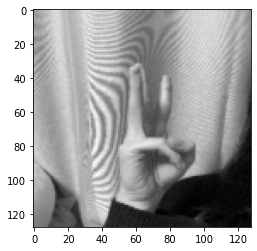

Label: 3


In [27]:
import cv2
import matplotlib.pyplot as plt

train_features, train_labels = next(iter(train_loader)) #iter는 반복 가능한 객체에서 이터레이터를 반환하고, 
                                                        #next는 이터레이터에서 값을 차례대로 꺼냅니다. 
img = train_features[0]
label = train_labels[0]
plt.imshow(img[0], cmap="gray")
plt.show()
print(f"Label: {label}")

In [28]:
print(f"Feature batch shape: {train_features.size()}")
print(f"Batch Labels shape: {train_labels}")

Feature batch shape: torch.Size([12, 3, 128, 128])
Batch Labels shape: tensor([3, 9, 1, 9, 3, 2, 3, 5, 7, 1, 2, 9])


In [29]:
from tqdm.auto import tqdm
import torch.nn as nn # 신경망들이 포함됨
#import torch.nn.init as init # 텐서에 초기값을 줌

class CNNclassification(torch.nn.Module):
    def __init__(self):
        super(CNNclassification, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.fc_layer = nn.Sequential( 
            nn.Linear(3136, 11) #fully connected layer(ouput layer)
        )    
        
    def forward(self, x):
        
        x = self.layer1(x) #1층
        
        x = self.layer2(x) #2층
         
        x = self.layer3(x) #3층
        
        x = self.layer4(x) #4층
        
        x = torch.flatten(x, start_dim=1) # N차원 배열 -> 1차원 배열
        
        out = self.fc_layer(x)
        return out


In [30]:
import torch.optim as optim # 최적화 알고리즘들이 포함힘

model = CNNclassification().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = None

In [44]:
def train(model, optimizer, train_loader, scheduler, device): 
    model.to(device)
    n = len(train_loader)
    
    #Loss Function 정의
    criterion = nn.CrossEntropyLoss().to(device)
    best_acc = 0
    
    for epoch in range(1,CFG["EPOCHS"]+1): #에포크 설정
        model.train() #모델 학습
        running_loss = 0.0
            
        for img, label in tqdm(iter(train_loader)):
            img, label = img.to(device), label.to(device) #배치 데이터
            optimizer.zero_grad() #배치마다 optimizer 초기화
        
            # Data -> Model -> Output
            logit = model(img) #예측값 산출
            loss = criterion(logit, label) #손실함수 계산
            
            # 역전파
            loss.backward() #손실함수 기준 역전파 
            optimizer.step() #가중치 최적화
            running_loss += loss.item()
              
        print('[%d] Train loss: %.10f' %(epoch, running_loss / len(train_loader)))
        
        if scheduler is not None:
            scheduler.step()
            
        #Validation set 평가
        model.eval() #evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수
        vali_loss = 0.0
        correct = 0
        with torch.no_grad(): #파라미터 업데이트 안하기 때문에 no_grad 사용
            for img, label in tqdm(iter(vali_loader)):
                img, label = img.to(device), label.to(device)

                logit = model(img)
                vali_loss += criterion(logit, label)
                pred = logit.argmax(dim=1, keepdim=True)  #11개의 class중 가장 값이 높은 것을 예측 label로 추출
                correct += pred.eq(label.view_as(pred)).sum().item() #예측값과 실제값이 맞으면 1 아니면 0으로 합산
        vali_acc = 100 * correct / len(vali_loader.dataset)
        print('Vail set: Loss: {:.4f}, Accuracy: {}/{} ( {:.0f}%)\n'.format(vali_loss / len(vali_loader), correct, len(vali_loader.dataset), 100 * correct / len(vali_loader.dataset)))
        
        #베스트 모델 저장
        if best_acc < vali_acc:
            best_acc = vali_acc
            torch.save(model.state_dict(), '/Users/yujaehyeon/Desktop/DACON/Sign Language Image classification/best_model.pth') #이 디렉토리에 best_model.pth을 저장
            print('Model Saved.')

In [45]:
train(model, optimizer, train_loader, scheduler, device)

  0%|          | 0/54 [00:00<?, ?it/s]

[1] Train loss: 2.3718118359


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3923, Accuracy: 29/215 ( 13%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[2] Train loss: 2.3397867017


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3308, Accuracy: 29/215 ( 13%)



  0%|          | 0/54 [00:00<?, ?it/s]

[3] Train loss: 2.2680711702


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.2828, Accuracy: 48/215 ( 22%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[4] Train loss: 2.1437923356


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.1639, Accuracy: 47/215 ( 22%)



  0%|          | 0/54 [00:00<?, ?it/s]

[5] Train loss: 1.9401931167


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.2269, Accuracy: 52/215 ( 24%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[6] Train loss: 1.7441100213


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.9838, Accuracy: 68/215 ( 32%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[7] Train loss: 1.5480187966


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.7536, Accuracy: 80/215 ( 37%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[8] Train loss: 1.2880395209


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.8205, Accuracy: 90/215 ( 42%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[9] Train loss: 1.1101038213


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.7770, Accuracy: 88/215 ( 41%)



  0%|          | 0/54 [00:00<?, ?it/s]

[10] Train loss: 0.9194289810


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.9687, Accuracy: 94/215 ( 44%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[11] Train loss: 0.7523946685


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.8637, Accuracy: 108/215 ( 50%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[12] Train loss: 0.6386288238


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.1203, Accuracy: 93/215 ( 43%)



  0%|          | 0/54 [00:00<?, ?it/s]

[13] Train loss: 0.5859769356


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.4651, Accuracy: 101/215 ( 47%)



  0%|          | 0/54 [00:00<?, ?it/s]

[14] Train loss: 0.4614744640


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.2724, Accuracy: 107/215 ( 50%)



  0%|          | 0/54 [00:00<?, ?it/s]

[15] Train loss: 0.3878943853


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.0056, Accuracy: 118/215 ( 55%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[16] Train loss: 0.3523988069


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.1892, Accuracy: 109/215 ( 51%)



  0%|          | 0/54 [00:00<?, ?it/s]

[17] Train loss: 0.1901727246


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.5059, Accuracy: 125/215 ( 58%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[18] Train loss: 0.2624804765


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3357, Accuracy: 119/215 ( 55%)



  0%|          | 0/54 [00:00<?, ?it/s]

[19] Train loss: 0.1799907031


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.7917, Accuracy: 119/215 ( 55%)



  0%|          | 0/54 [00:00<?, ?it/s]

[20] Train loss: 0.1807770991


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.8204, Accuracy: 128/215 ( 60%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[21] Train loss: 0.1343438475


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.5951, Accuracy: 125/215 ( 58%)



  0%|          | 0/54 [00:00<?, ?it/s]

[22] Train loss: 0.1453191873


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.7913, Accuracy: 115/215 ( 53%)



  0%|          | 0/54 [00:00<?, ?it/s]

[23] Train loss: 0.0974674889


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.6534, Accuracy: 132/215 ( 61%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[24] Train loss: 0.1017806615


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.6052, Accuracy: 130/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[25] Train loss: 0.0546290483


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.8935, Accuracy: 121/215 ( 56%)



  0%|          | 0/54 [00:00<?, ?it/s]

[26] Train loss: 0.0641704320


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.9428, Accuracy: 125/215 ( 58%)



  0%|          | 0/54 [00:00<?, ?it/s]

[27] Train loss: 0.0580903942


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.8682, Accuracy: 127/215 ( 59%)



  0%|          | 0/54 [00:00<?, ?it/s]

[28] Train loss: 0.0264241868


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.9000, Accuracy: 124/215 ( 58%)



  0%|          | 0/54 [00:00<?, ?it/s]

[29] Train loss: 0.0394854155


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.8670, Accuracy: 127/215 ( 59%)



  0%|          | 0/54 [00:00<?, ?it/s]

[30] Train loss: 0.0347740846


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.9247, Accuracy: 127/215 ( 59%)



  0%|          | 0/54 [00:00<?, ?it/s]

[31] Train loss: 0.0254359347


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.8569, Accuracy: 126/215 ( 59%)



  0%|          | 0/54 [00:00<?, ?it/s]

[32] Train loss: 0.0152795343


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.1209, Accuracy: 126/215 ( 59%)



  0%|          | 0/54 [00:00<?, ?it/s]

[33] Train loss: 0.0146936186


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.1307, Accuracy: 129/215 ( 60%)



  0%|          | 0/54 [00:00<?, ?it/s]

[34] Train loss: 0.0176424810


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.2108, Accuracy: 125/215 ( 58%)



  0%|          | 0/54 [00:00<?, ?it/s]

[35] Train loss: 0.0064424890


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.3454, Accuracy: 123/215 ( 57%)



  0%|          | 0/54 [00:00<?, ?it/s]

[36] Train loss: 0.0043713266


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.3594, Accuracy: 127/215 ( 59%)



  0%|          | 0/54 [00:00<?, ?it/s]

[37] Train loss: 0.0033917011


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.5472, Accuracy: 124/215 ( 58%)



  0%|          | 0/54 [00:00<?, ?it/s]

[38] Train loss: 0.0016382521


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.6299, Accuracy: 124/215 ( 58%)



  0%|          | 0/54 [00:00<?, ?it/s]

[39] Train loss: 0.0011999622


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.7089, Accuracy: 124/215 ( 58%)



  0%|          | 0/54 [00:00<?, ?it/s]

[40] Train loss: 0.0010117466


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.7780, Accuracy: 124/215 ( 58%)



  0%|          | 0/54 [00:00<?, ?it/s]

[41] Train loss: 0.0008738668


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.8380, Accuracy: 124/215 ( 58%)



  0%|          | 0/54 [00:00<?, ?it/s]

[42] Train loss: 0.0007843193


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.8933, Accuracy: 124/215 ( 58%)



  0%|          | 0/54 [00:00<?, ?it/s]

[43] Train loss: 0.0006933689


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.9439, Accuracy: 124/215 ( 58%)



  0%|          | 0/54 [00:00<?, ?it/s]

[44] Train loss: 0.0006357279


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.9890, Accuracy: 125/215 ( 58%)



  0%|          | 0/54 [00:00<?, ?it/s]

[45] Train loss: 0.0005958564


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 4.0329, Accuracy: 125/215 ( 58%)



  0%|          | 0/54 [00:00<?, ?it/s]

[46] Train loss: 0.0005413777


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 4.0712, Accuracy: 126/215 ( 59%)



  0%|          | 0/54 [00:00<?, ?it/s]

[47] Train loss: 0.0004977727


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 4.1081, Accuracy: 126/215 ( 59%)



  0%|          | 0/54 [00:00<?, ?it/s]

[48] Train loss: 0.0004657335


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 4.1414, Accuracy: 126/215 ( 59%)



  0%|          | 0/54 [00:00<?, ?it/s]

[49] Train loss: 0.0004413877


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 4.1752, Accuracy: 126/215 ( 59%)



  0%|          | 0/54 [00:00<?, ?it/s]

[50] Train loss: 0.0004147057


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 4.2055, Accuracy: 126/215 ( 59%)



In [46]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.to(device)

            pred_logit = model(img)
            pred_logit = pred_logit.argmax(dim=1, keepdim=True).squeeze(1)

            model_pred.extend(pred_logit.tolist())
    return model_pred

In [48]:
test_dataset = CustomDataset(test_img_path, None, train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# Validation Accuracy가 가장 뛰어난 모델을 불러옵니다.
checkpoint = torch.load('/Users/yujaehyeon/Desktop/DACON/Sign Language Image classification/best_model.pth')
model = CNNclassification().to(device)
model.load_state_dict(checkpoint)

# Inference
preds = predict(model, test_loader, device)
preds[0:5]

  0%|          | 0/18 [00:00<?, ?it/s]

[1, 2, 1, 1, 5]

In [52]:
submission = pd.read_csv('/Users/yujaehyeon/Desktop/DACON/Sign Language Image classification/data/user_data/sample_submission.csv')
submission['label'] = preds

In [53]:
submission['label'][submission['label'] == 10] = '10-1' ## label : 10 -> '10-1'
submission['label'][submission['label'] == 0] = '10-2' ## Label : 0 -> '10-2'
submission['label'] = submission['label'].apply(lambda x : str(x)) ## Dtype : int -> object

/var/folders/hn/lsy2f4r16klfx3jt0tq69mh80000gn/T/ipykernel_72612/3411836075.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['label'][submission['label'] == 10] = '10-1' ## label : 10 -> '10-1'


In [54]:
submission.head()

,file_name,label
0,001.png,1
1,002.png,2
2,003.png,1
3,004.png,1
4,005.png,5


In [55]:
submission.to_csv('submit.csv', index=False)